In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop
from backprop import gp, crossover as gp_crossover, selector as gp_selector
from backprop import library, project, diversify
from gp import evaluator as gp_evaluator
from symbols import syntax_tree

In [2]:
SAMPLE_SIZE = 300
NOISE       = 0.03

POPSIZE         = 1000
MAX_STREE_DEPTH = 5
GENERATIONS     = 50
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

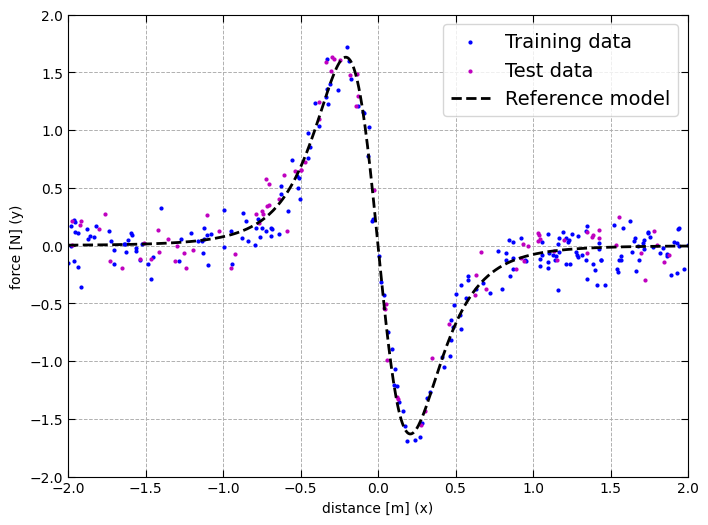

In [3]:
S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=0.7)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [ ]:
syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp.MultiMutator(
      gp.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp.FunctionSymbolMutator(),
      gp.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

#evaluator = gp.R2Evaluator(S_train)
#evaluator = gp.FUEvaluator(S_train, S.knowledge)
#evaluator = gp.NumericalFUEvaluator(S_train, S.knowledge)
evaluator = gp_evaluator.FastFUEvaluator(S_train, S.knowledge)

selector = gp.TournamentSelector(GROUP_SIZE)

crossover = gp.SubTreeCrossover(MAX_STREE_DEPTH)
#crossover = gp_crossover.ApproxGeometricCrossover(lib, MAX_STREE_DEPTH, diversifier)
#crossover = gp_crossover.CrossNPushCrossover(lib, MAX_STREE_DEPTH)
#crossover = gp_crossover.ConstrainedCrossNPushCrossover(lib, MAX_STREE_DEPTH, evaluator.know_evaluator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

with np.errstate(all='ignore'):
      import profiling

      with tqdm(total=symb_regressor.ngen-1) as pbar:
            def on_newgen(genidx, status):
                  pbar.update(1)
                  pbar.set_description(status)
            best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)
      
      profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)

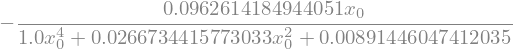

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

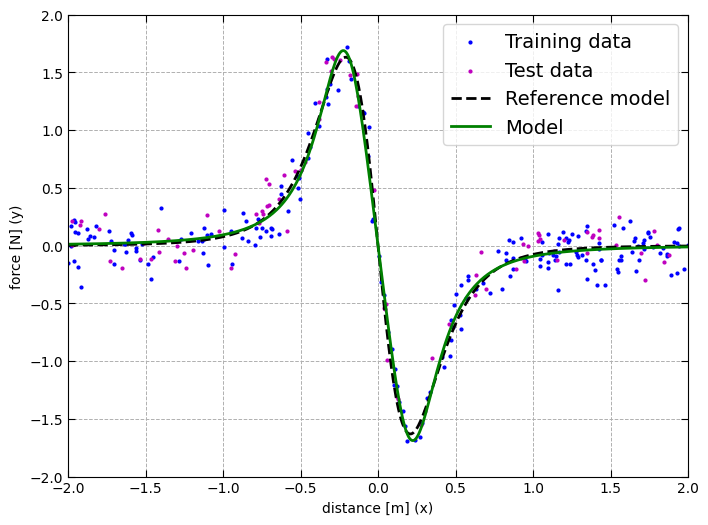

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

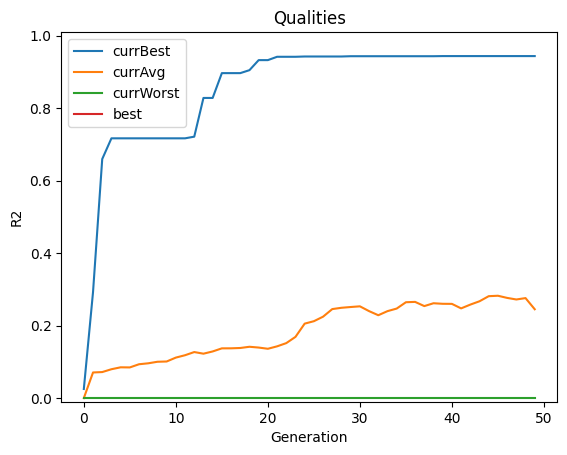

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

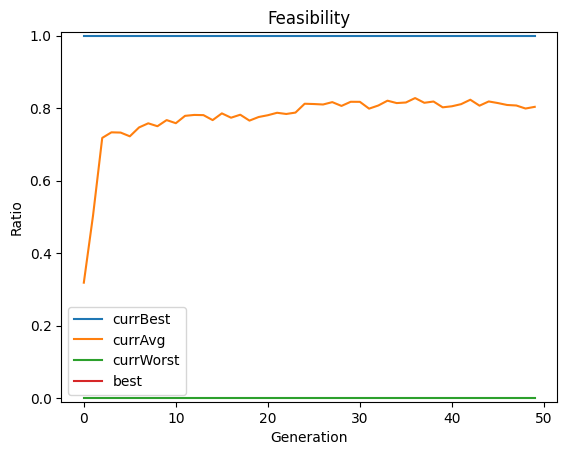

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

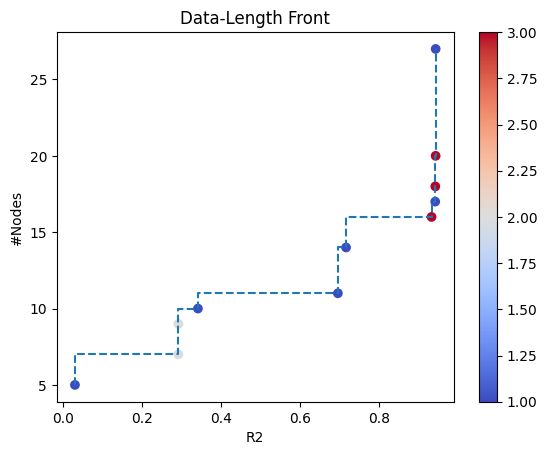

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((x0 * 0.08) / -0.99),0,0.006086,0.030430,5,(),1,inf
1,1,((((x0 / 0.69) / square(x0)) / (square((x0 / x...,0,0.034958,0.943870,27,"(/, exp, square, sqrt, +)",1,inf
2,2,(((x0 / exp(square(x0))) * -0.76) / sqrt(squar...,0,0.063298,0.696273,11,"(/, sqrt, square, exp)",1,0.592446
3,3,((x0 * -0.22) / (exp(x0) - (x0 + 0.90))),0,0.034190,0.341895,10,"(/, +, exp)",1,0.532810
4,4,((((exp(1.43) * x0) / exp(square(x0))) * -0.22...,0,0.051213,0.716979,14,"(/, *, exp, square, sqrt)",1,0.486941
5,5,((x0 * -0.30) / sqrt(square(x0))),0,0.041749,0.292244,7,"(/, sqrt, square)",2,0.468858
6,6,((sqrt(0.74) / (x0 * -0.22)) / ((x0 / x0) + (s...,0,0.047190,0.943803,20,"(/, sqrt, square, +)",3,0.410088
7,7,((sqrt(0.74) / (x0 * -0.22)) / (square((x0 / 0...,0,0.058342,0.933464,16,"(/, sqrt, square, +)",3,0.383508
8,8,(((x0 * 0.13) / -0.43) / sqrt(square(x0))),0,0.032514,0.292624,9,"(/, sqrt, square)",2,0.190720
9,9,((sqrt(0.74) / (x0 * -0.22)) / (0.74 + (square...,0,0.052387,0.942959,18,"(/, sqrt, square, +)",3,0.137538


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)